# Dataset loader and splitter

0. import libraries

In [20]:
import os
import numpy as np
import pandas as pd
import json
import torch, torchvision
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import PIL 
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
import math
import nltk
import FlickrDataset
import Vocabulary
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import Image, display
import MyCollate

1. Load the Karpathy split set, create the needed split lists and append to the right variables

In [21]:
f = open('dataset_flickr30k.json')
dataset = json.load(f)

In [22]:
train_imgs = list()
man_woman_images = list()
train_labels = list()
val_imgs = list()
val_labels = list()
test_imgs = list()
test_labels = list()
all_labels = list()

In [23]:
from logging import error
import os, shutil

path = 'flickr/flickr30k_images/'
destinations = ['train', 'test', 'val']
for elem in destinations:
        if not os.path.exists(path+elem):
                os.makedirs(path+elem)
                
                
for img in dataset['images']:  
        tokenlist = []
        for sentence in img['sentences']:
                tokenlist.append(sentence['tokens'])
                                
        if img['split'] == 'train':
                
                train_imgs.append(img['filename'])
                train_labels.append(tokenlist)
                all_labels.append(tokenlist) 
                if 'man'  in tokenlist or 'woman' in tokenlist:
                        if img['filename'] not in man_woman_images:
                                man_woman_images.append(img['filename'])
                
        if img['split'] == 'test':
        
                test_imgs.append(img['filename'])
                test_labels.append(tokenlist)
                all_labels.append(tokenlist)
        
        if img['split'] == 'val':
                
                val_imgs.append(img['filename'])
                val_labels.append(tokenlist)
                all_labels.append(tokenlist)
        
                

Pour un premier essay des modeles de detection d'objets, nous allons créer un jeu de données contenant principalement les classes homme et femme. 

In [24]:
import random

random.shuffle(man_woman_images)

train_man_woman = man_woman_images[:100]
test_man_woman = man_woman_images[101:151]


In [25]:
dict_tokens = dict()
imgs_idx = dict()
idx_imgs = dict()
for idx, img in enumerate(dataset['images']):
    dict_tokens[idx] = [sentence['tokens'] for sentence in img['sentences']]   
    imgs_idx[img['filename']] = idx
    idx_imgs[idx] = img['filename']   

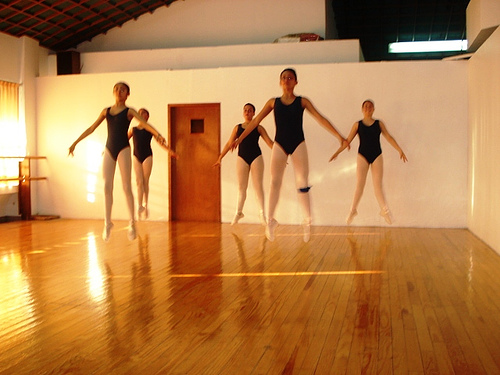

[['five', 'ballet', 'dancers', 'caught', 'mid', 'jump', 'in', 'a', 'dancing', 'studio', 'with', 'sunlight', 'coming', 'through', 'a', 'window'], ['ballet', 'dancers', 'in', 'a', 'studio', 'practice', 'jumping', 'with', 'wonderful', 'form'], ['five', 'girls', 'are', 'leaping', 'simultaneously', 'in', 'a', 'dance', 'practice', 'room'], ['five', 'girls', 'dancing', 'and', 'bending', 'feet', 'in', 'ballet', 'class'], ['a', 'ballet', 'class', 'of', 'five', 'girls', 'jumping', 'in', 'sequence']]


In [26]:
display(Image(filename=path + 'train/' + train_imgs[10]))
print(train_labels[10])

In [27]:
with open(path+'train/train.txt', 'w', encoding='utf-8') as f:
                        f.write('\n'.join(train_imgs))

with open(path+'train/man_woman.txt', 'w', encoding='utf-8') as f:
                        f.write('\n'.join(train_imgs))                      
with open(path+'test/test.txt', 'w', encoding='utf-8') as f:
                        f.write('\n'.join(test_imgs))
                        
with open(path+'val/val.txt', 'w', encoding='utf-8') as f:
                        f.write('\n'.join(val_imgs))

with open(path+'homme_femme/homme_femme_train.txt', 'w', encoding='utf-8') as f:
                        f.write('\n'.join(train_man_woman))

with open(path+'homme_femme/homme_femme_test.txt', 'w', encoding='utf-8') as f:
                        f.write('\n'.join(test_man_woman))

In [28]:
dict_tokens = dict()
imgs_idx = dict()
idx_imgs = dict()

for idx, img in enumerate(dataset['images']):
    dict_tokens[idx] = [sentence['tokens'] for sentence in img['sentences']]   
    imgs_idx[img['filename']] = idx
    idx_imgs[idx] = img['filename']

In [29]:
def get_loader(root_folder, 
               imgs, 
               labels,
               vocab,
               transforms, 
               imgs_idx,
               batch_size = 32, 
               shuffle=True
               ):
    dataset = FlickrDataset.FlickrDataset(root_folder, imgs, labels, vocab, transforms, imgs_idx)
    
    print('Dataset made!')
    
    loader = DataLoader(
        dataset = dataset,
        batch_size = batch_size,
        shuffle = shuffle,
        collate_fn = MyCollate.MyCollate(pad_idx = dataset.vocab.stoi["<PAD>"])
    )
    
    print('Loader made!')

    return loader, dataset

In [30]:
vocab = Vocabulary.Vocabulary(5)
vocab.build_vocabulary(all_labels)

Start building vocabulary!
Vocabulary built!


In [31]:
print('Lenght of the vocabulary: {}'.format(len(vocab)))

Lenght of the vocabulary: 7652


In [32]:
print('The most frequent word is: {}'.format(max(vocab.freq, key=vocab.freq.get)))

The most frequent word is: a


As expected, the most frequent word is a stopword. We will copy the frequencies dictionary without stopwords in a variable.

In [33]:
stopwords = nltk.corpus.stopwords.words('english')

vocab_no_stopwords = vocab.freq
to_delete = []
for key, value in vocab_no_stopwords.items():
    if key in stopwords:
        to_delete.append(key)
for word in to_delete:
    del vocab_no_stopwords[word]
    
print('The most frequent word is: {}'.format(max(vocab_no_stopwords, key=vocab_no_stopwords.get)))    

The most frequent word is: man


The most frequent 'object' is man. 

In [34]:
print(sorted(vocab_no_stopwords.items(), key=lambda item: item[1], reverse = True)[:20])

[('man', 41564), ('woman', 21582), ('two', 21100), ('people', 17024), ('wearing', 15373), ('shirt', 14083), ('white', 12971), ('young', 12857), ('black', 12131), ('blue', 11155), ('red', 10053), ('sitting', 9433), ('men', 9309), ('girl', 9209), ('boy', 8993), ('standing', 8852), ('dog', 8738), ('playing', 8450), ('street', 7861), ('group', 7733)]


In [35]:
vocab_no_stopwords.keys()
text = " ".join(x for x in vocab_no_stopwords.keys())
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

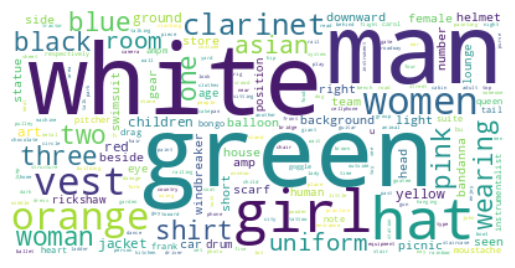

In [36]:
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Man and woman are the most common words. 

Let's create the data loader and the dataset

In [37]:
torch.manual_seed(17)
transformations_train = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
        ])
            
        
    

transformations_test = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
        ])


Pour la simplicité, les splits ont déja été fait et sont téléchargeables

In [42]:
%cd flickr/flickr30k_images
!wget https://seafile.unistra.fr/f/32c84639422d42beac70/?dl=1 -O split.zip
!unzip split.zip
%cd ../..

--2022-12-28 22:48:01--  https://seafile.unistra.fr/f/32c84639422d42beac70/?dl=1
Resolving seafile.unistra.fr (seafile.unistra.fr)... 77.72.44.41
Connecting to seafile.unistra.fr (seafile.unistra.fr)|77.72.44.41|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://seafile.unistra.fr/seafhttp/files/9df0c5e0-9f6a-4c55-8432-86e568a176b7/flickr.zip [following]
--2022-12-28 22:48:01--  https://seafile.unistra.fr/seafhttp/files/9df0c5e0-9f6a-4c55-8432-86e568a176b7/flickr.zip
Reusing existing connection to seafile.unistra.fr:443.
HTTP request sent, awaiting response... 200 OK
Length: 4275812890 (4,0G) [application/zip]
Saving to: ‘split.zip’

split.zip            10%[=>                  ] 416,01M  3,96MB/s    eta 15m 10s^C
Archive:  split.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
 

In [43]:
train_loader, train_dataset = get_loader(
        root_folder="flickr/flickr30k_images/train",
        imgs=train_imgs,
        labels=train_labels,
        vocab=vocab,
        transforms=transformations_train,
        batch_size=80,
        imgs_idx = imgs_idx
    )
val_loader, val_dataset = get_loader(
        root_folder="flickr/flickr30k_images/val",
        imgs=val_imgs,
        labels=val_labels,
        vocab=vocab,
        transforms=transformations_test,
        batch_size=80,
        imgs_idx = imgs_idx
    )

test_loader, test_dataset = get_loader(
        root_folder="flickr/flickr30k_images/test",
        imgs=test_imgs,
        labels=val_labels,
        vocab=vocab,
        transforms=transformations_test,
        batch_size=80,
        imgs_idx = imgs_idx
    )

Dataset made!


TypeError: 'list' object cannot be interpreted as an integer

In [ ]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

tensor_to_image(train_dataset[10][0][0])

NameError: name 'train_dataset' is not defined

Nous allons maintenant prendre notre jeu de données contenant que femme et homme et ajouter les bounding boxes

## Encodeur pré-entrainé

In [1]:
import encoderCNN_pretrained
from feature_extractor import FeatureExtractor
from torchinfo import summary

enc = encoderCNN_pretrained.EncoderCNN()


In [5]:
from torchvision.utils import draw_bounding_boxes
import cv2 
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image


def object_detection_api(img_path, threshold=0.9, rect_th=3, text_size=3, text_th=3): 
        img, imgT, boxes, pred_cls, weights = enc.get_prediction(img_path, threshold)  # Get predictions 
        print(pred_cls)
        resnet_features = FeatureExtractor(enc.model, layers=['backbone.body.layer4', 'backbone.fpn', 'rpn', 'roi_heads.box_roi_pool', 'backbone.body.layer3', 'roi_heads', 'roi_heads.box_roi_pool', 'backbone'])
        features = resnet_features([imgT])
        labels = [weights.meta["categories"][i] for i in pred_cls]
        box = draw_bounding_boxes(img, boxes=boxes,
                                  labels=labels,
                                  colors="red",
                                  width=4)#, font_size=30)
        im = to_pil_image(box.detach())
        im
        return im, features, boxes, pred_cls

In [16]:
image, features, boxes, pred_cls = object_detection_api('flickr/flickr30k_images/dump/4887197825.jpg', threshold = 0.9, rect_th=1, text_size=1, text_th=1 )

tensor([1, 1, 1, 4])


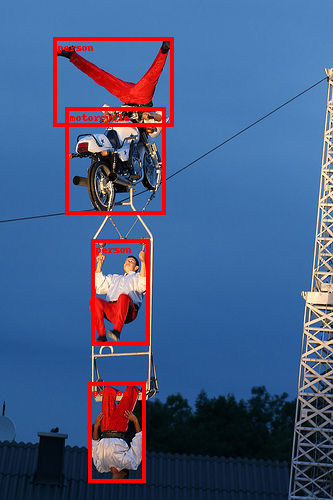

In [17]:
image

In [13]:
from torchvision import models
features['roi_heads.box_roi_pool'].size()

torch.Size([988, 256, 7, 7])

In [12]:
features['roi_heads.box_roi_pool']

tensor([[[[ 3.6429e-02,  1.6462e-01,  1.7734e-01,  ..., -7.2451e-03,
            2.0491e-02,  2.3514e-02],
          [ 6.8138e-02,  1.4110e-01,  2.2676e-02,  ..., -5.7030e-03,
           -6.9348e-02,  1.4841e-03],
          [ 9.5765e-02,  2.1607e-01,  1.1225e-01,  ...,  7.0957e-02,
            1.2430e-01, -2.6445e-02],
          ...,
          [-2.8475e-02,  6.0956e-03, -4.9930e-02,  ...,  6.9611e-02,
            5.3105e-03,  1.5153e-03],
          [ 9.7265e-02,  4.4355e-02, -2.9099e-02,  ...,  9.1829e-02,
            1.6416e-01,  5.9653e-02],
          [ 3.8615e-01,  3.4730e-01,  2.2255e-01,  ...,  9.2462e-03,
            1.4602e-01,  8.8613e-02]],

         [[ 1.1163e-01, -1.3041e-01, -2.4405e-01,  ...,  1.7204e-01,
            1.7751e-01, -3.2879e-02],
          [ 1.7295e-01,  1.1966e-01, -1.2960e-01,  ..., -3.7476e-03,
            1.4990e-01,  7.5032e-02],
          [ 1.0689e-01,  4.9439e-02,  7.2229e-02,  ..., -3.7367e-01,
           -4.3486e-01,  2.2378e-02],
          ...,
     

In [ ]:
features['backbone.fpn'][''].size()

torch.Size([1, 256, 13, 17])

In [ ]:
boxes

[[(53.336525, 211.70982), (189.08585, 363.31348)],
 [(203.39767, 128.3905), (286.12576, 157.29152)],
 [(184.30847, 237.03862), (284.9629, 354.53183)],
 [(19.351887, 141.38075), (31.007357, 145.4491)]]